<a href="https://colab.research.google.com/github/mamarig/Prueba/blob/master/Copia_de_Proyecto_2_1_AED_en_un_Proceso_de_Galvanizado_de_Bobinas_de_Acero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2020/2021
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Proyecto 2. Diseño de DSS en Industria 4.0 (Parte 1/3)

En este ejemplo, como continuación del Proyecto 2, vamos a utlizar Python para profundizar en el desarrollo de modelos predictivos que puedan ser usados en una planta de galvanizado de bobinas de acero.

En este proyecto se pretende tener una experiencia cercana a aspectos propios de la Industria 4.0 como el Big Data y la Simulación.

![Industria 4.0](https://blog.wearedrew.co/hubfs/Industria-4-0.gif)

Lógicamente, el proceso de extracción, captura de la información y selección dentro de las miles de variables, ha sido realizado previamente. En nuestro caso, trabajaremos con una base de datos ya reducida y limpia, preparada para un contexto de aprendizaje. Esta Base de Datos está modificada para conservar la confidencialidad con la empresa.

Recordando lo visto en la primera parte de esta práctica, el objetivo consiste en desarrollar modelos que puedan ser utilizados para controlar y optimizar el proceso de recocido de una línea de galvanizado en continuo de bobinas de acero (línea de subida de la curva de recocido).
1. Caso A: Modelos de predicción de la temperatura de consigna del horno en la zona 1 del horno (THC1) según la temperatura de entrada de la banda, la temperatura a la que debe salir la banda, la velocidad de la banda, las dimensiones de la banda de acero y el tipo de acero de la misma.
2. Caso B: Modelo de predicción que permita predecir la temperatura de la banda de acero cuando sale del horno (TMPP2) según las temperaturas del horno (THC1, THC3 y THC5), la temperatura de entrada de la banda de acero (TMPP1), la velocidad de la banda (VELMED), dimensiones y tipo de acero.

![](http://templete.8directo.com/wp-content/uploads/sites/2/2018/02/Acerinox.jpg)

In [2]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

## Cargamos la Base de Datos

In [3]:
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff -O DATOS_HORNO_ENTRENA.arff
!wget https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_TESTEO.arff -O DATOS_HORNO_TESTEO.arff

--2021-04-25 15:06:12--  https://github.com/IC1920/Datasets/raw/master/DATOS_HORNO_ENTRENA.arff
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff [following]
--2021-04-25 15:06:13--  https://raw.githubusercontent.com/IC1920/Datasets/master/DATOS_HORNO_ENTRENA.arff
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125832 (123K) [text/plain]
Saving to: ‘DATOS_HORNO_ENTRENA.arff’

DATOS_HORNO_ENTRENA 100%[===================>] 122.88K  --.-KB/s    in 0.02s   

2021-04-25 15:06:13 (5.43 MB/s) - ‘DATOS_HORNO_ENTRENA.arff’ saved [125832/125832]

--2021-04-25

In [4]:
# Leemos los archivos arff
df_train = pd.DataFrame(arff.loadarff("DATOS_HORNO_ENTRENA.arff")[0])
df_test = pd.DataFrame(arff.loadarff("DATOS_HORNO_TESTEO.arff")[0])

In [5]:
df_train.head()

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006.0,b'B011F97',1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007.0,b'B011F97',1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008.0,b'B011F97',1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0
3,23293009.0,b'B011F97',1250.0,0.6,903.0,5330.0,145.0,221.0,755.0,750.0,758.0,788.0,811.0
4,23293010.0,b'B011F97',1250.0,0.6,2540.0,15030.0,105.0,223.0,752.0,750.0,752.0,783.0,806.0


Vemos que al leer nos han incluido un caracter 'b' en el código de la bobina y comillas simples. Procedemos a decodificarlo como formato *utf-8*.mando 'replace'

In [6]:
# Convertimos la variable CLASACERO a utf-8
df_train['CLASACERO'] = df_train['CLASACERO'].str.decode('utf-8')
df_test['CLASACERO'] = df_test['CLASACERO'].str.decode('utf-8')
df_train.head()

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006.0,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007.0,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008.0,B011F97,1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0
3,23293009.0,B011F97,1250.0,0.6,903.0,5330.0,145.0,221.0,755.0,750.0,758.0,788.0,811.0
4,23293010.0,B011F97,1250.0,0.6,2540.0,15030.0,105.0,223.0,752.0,750.0,752.0,783.0,806.0


La descripción de las variables de la base de datos es la siguiente:

-	CODBOB: Código de la bobina.
-	CLASACERO: Tipo de acero.
-	ANCHO: Ancho medio de la banda de acero. (mm)
-	ESPESOR: Espesor medio de la banda de acero. (mm).
-	LARGO: Largo medio de la banda de acero. (m).
-	PESO: Peso medio de la bobina. (Kg*10).
-	VELMED: Velocidad media de la banda de acero en el horno. (m/min)
-	TMPP1: Temperatura media de la banda de acero a la entrada del horno. (ºC)
-	TMPP2: Temperatura media de la banda de acero a la salida del horno. (ºC)
-	TMPP2CNG: Temperatura media objetivo que debería tener la banda de acero a la salida del horno. (ºC)
-	THC1: Temperatura media de consigna en la zona 1 del Horno. (ºC)
-	THC3: Temperatura media de consigna en la zona 3 del Horno. (ºC).
-	THC5: Temperatura media de consigna en la zona 5 del Horno. (ºC)

En este caso, los valores de temperatura del horno, de la banda de acero y de velocidad de la misma corresponden con los valores medios obtenidos para cada una de las bobinas.


In [7]:
df_test.head()

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23633053.0,B105F55,1040.0,0.7,3491.0,19780.0,136.0,256.0,851.0,850.0,858.0,888.0,914.0
1,23633054.0,B105F55,1040.0,0.7,3240.0,18370.0,140.0,258.0,850.0,850.0,860.0,890.0,914.0
2,23633055.0,B105F55,1040.0,0.7,3047.0,17160.0,140.0,260.0,850.0,850.0,860.0,890.0,914.0
3,23633056.0,B105F55,1040.0,0.7,3513.0,19980.0,139.0,263.0,842.0,840.0,854.0,884.0,906.0
4,23643001.0,B100F55,1062.0,0.7,2949.0,17050.0,139.0,253.0,829.0,825.0,847.0,877.0,895.0


In [8]:
np.unique(df_train['CLASACERO'])

array(['B011B99', 'B011F97', 'B012B97', 'B012F53', 'B012F55', 'B013B55',
       'B013C55', 'B014F53', 'B016F35', 'B023H53', 'B025F55', 'B032H53',
       'B042H53', 'B044H53', 'B081B99', 'B085F97', 'B085G99', 'B100B95',
       'B100F33', 'B100F55', 'B101F55', 'B102G33', 'B102G55', 'B103G33',
       'B103G55', 'B105F55', 'B120G55', 'C107G55', 'C114G55', 'C115G55',
       'C116G55', 'D012F55', 'D012G99', 'D031B33', 'D032F55', 'D071F55',
       'D094B33', 'D094G55', 'K011B55', 'K011F57', 'K021H43', 'K021H53',
       'K022H53', 'N013H53', 'N017B97', 'X100G99'], dtype=object)

También convertimos el código de la bobina a entero.

In [9]:
df_train['CODBOB'] = df_train['CODBOB'].astype(int)
df_test['CODBOB'] = df_test['CODBOB'].astype(int)

display(df_train.head(3), df_test.head(3))

,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23293006,B011F97,1250.0,0.6,3683.0,21770.0,145.0,212.0,754.0,750.0,770.0,800.0,821.0
1,23293007,B011F97,1250.0,0.6,3040.0,18070.0,145.0,210.0,749.0,750.0,772.0,801.0,822.0
2,23293008,B011F97,1250.0,0.6,3605.0,21420.0,138.0,211.0,761.0,770.0,778.0,808.0,833.0


,CODBOB,CLASACERO,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
0,23633053,B105F55,1040.0,0.7,3491.0,19780.0,136.0,256.0,851.0,850.0,858.0,888.0,914.0
1,23633054,B105F55,1040.0,0.7,3240.0,18370.0,140.0,258.0,850.0,850.0,860.0,890.0,914.0
2,23633055,B105F55,1040.0,0.7,3047.0,17160.0,140.0,260.0,850.0,850.0,860.0,890.0,914.0


In [10]:
df_train.shape, df_test.shape #Tamaño final de las bases de datos

((1898, 13), (81, 13))

## Análisis Exploratorio de Datos

In [11]:
df_train.describe() # Describe variables numéricas

,CODBOB,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
count,1.898000e+03,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000,1898.000000
mean,2.346880e+07,1175.884615,0.888298,2392.461538,17488.838778,108.591675,249.407798,807.407798,806.642782,815.469442,845.613277,865.016860
std,9.847295e+04,197.816664,0.348482,1044.062929,5014.451152,46.984315,19.790073,32.183468,32.415592,37.621038,38.236909,39.908894
min,2.329301e+07,750.000000,0.430000,350.000000,1380.000000,30.000000,200.000000,715.000000,725.000000,702.000000,734.000000,734.000000
25%,2.338304e+07,1000.000000,0.650000,1631.250000,14140.000000,87.000000,234.000000,790.000000,783.000000,795.000000,825.000000,840.000000
50%,2.346307e+07,1220.000000,0.770000,2186.500000,18695.000000,113.000000,250.000000,821.000000,825.000000,824.500000,854.000000,874.000000
75%,2.355304e+07,1301.000000,1.170000,3102.750000,21380.000000,125.000000,265.000000,826.000000,825.000000,844.000000,875.000000,894.000000
max,2.363305e+07,1525.000000,2.000000,5538.000000,26340.000000,999.000000,300.000000,867.000000,861.000000,877.000000,907.000000,932.000000


Vamos a ver la distribución de los datos para identificar valores anómalos

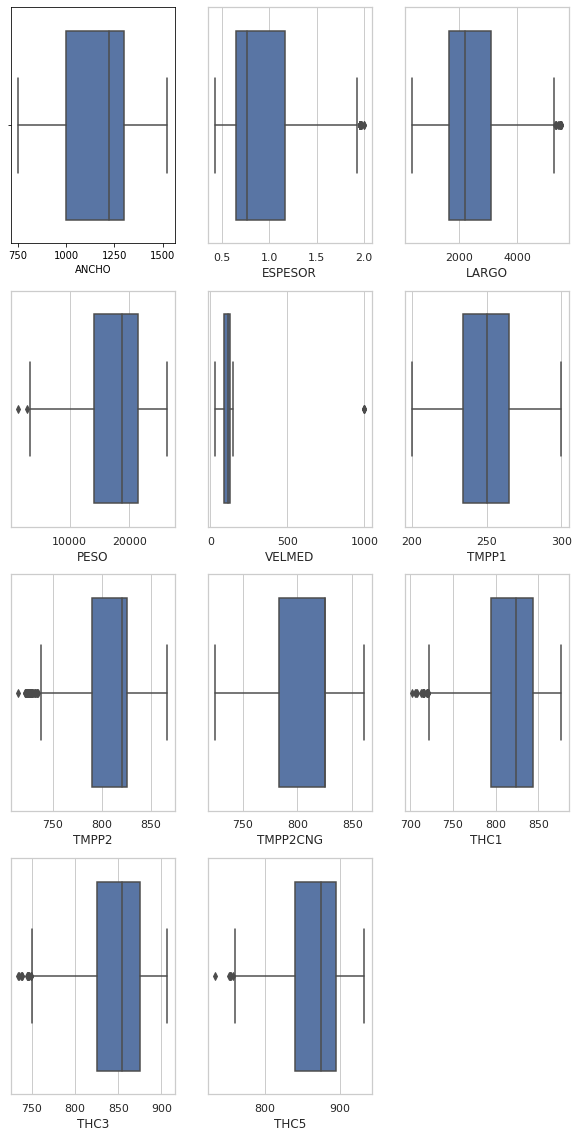

In [12]:
# %config InlineBackend.figure_format = 'svg' # formato vectorial
fig = plt.figure(figsize=(10,20))
for ncol, columna in enumerate(df_train.columns[2:]):
    plt.subplot(4,3,ncol+1)
    sns.set(style="whitegrid")
    ax = sns.boxplot(x=df_train[columna], data=df_train)

Vemos algo extraño en la variable VELMED. Vamos a ver cuantos casos hay mayores de 500 metros por minuto y los eliminamos de la base de datos porque el proceso no permite velocidades de banda tan altas.

In [13]:
np.sum(df_train['VELMED']>500)

4

In [14]:
df_train = df_train.loc[df_train['VELMED']<500] # Nos quedamos con los casos menores de 500

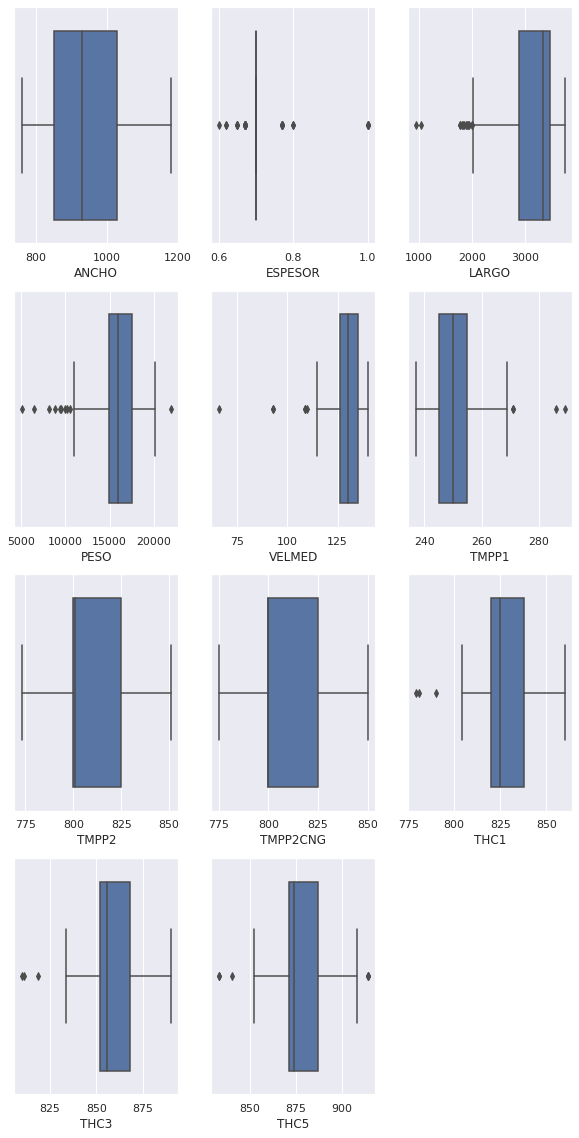

In [15]:
# %config InlineBackend.figure_format = 'svg' # formato vectorial
sns.set(style="darkgrid")
fig = plt.figure(figsize=(10,20))
for ncol, columna in enumerate(df_test.columns[2:]):
    plt.subplot(4,3,ncol+1)
    ax = sns.boxplot(x=df_test[columna], data=df_train)

**EJERCICIO: Analiza los diagramas de cajas de las celdas anteriores y escribe tus conclusiones. Incluye el codigo que consideres necesario para justificar las mismas.**

La primera celda con diagramas de cajas y bigotes representa la base de datos de entrenamiento, en la cual como se puede observar las variables PESO, THPP2, TH1, TH3 y TH5 tienen valores atípicos en la parte izquierda y las variables ESPESOR y LARGO en la parte derecha.

Las variables que no tienen nigún valor atípico son: ANCHO, TMPP1 y TMPP2CNG. En la variable TMPP2CNG parece que no está representada la mediana pero si que lo está el valor de esta es igual al cuartil Q3.

Para terminar, en la variable VELMED al eliminar los casos mayores de 500 metros por minuto el diagrama se puede ver más ampliado y se puede comprobar que no tiene ningún valor atípico.

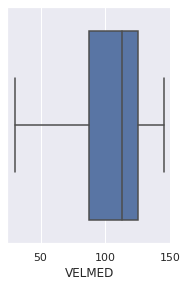

In [16]:
# Diagrama VELMED
fig = plt.figure(figsize=(10,20))
for ncol, columna in enumerate(df_train.columns[6:7]):
    plt.subplot(4,3,ncol+1)
    sns.set(style="whitegrid")
    ax = sns.boxplot(x=df_train[columna], data=df_train)

En la segunda celda representa los diagramas de cajas y bigotes que corresponden con la base de datos de testeo. Como se puede observar las variables con valores atípicos a la izquierda son: LARGO, VELMED, TH1 y TH3. Las que tienen valores atípicos a la derecha es TMPP1 y en ambos lados PESO y TH5.

Las variables que no tienen nigún valor atípico son: ANCHO, TMPP2 y TMPP2CNG, estas dos últimas variables tiene la mediana muy próxima al cuartil Q1.

Para terminar, la variable ESPESOR tiene una representación un poco extraña, esto es debido a que los cuatiles Q1, Q3 y la mediana tienen el mismo valor (0.7), en este caso se representa con una línea y el mínima (0.6) y el máximo (1.0) con un punto.

A continuación se muestra la tabla con todos los valores estadísticos de todas las variables.


In [17]:
df_test.describe()

,CODBOB,ANCHO,ESPESOR,LARGO,PESO,VELMED,TMPP1,TMPP2,TMPP2CNG,THC1,THC3,THC5
count,8.100000e+01,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,2.364476e+07,932.407407,0.716667,3025.345679,15657.172840,127.654321,251.123457,811.901235,811.617284,827.666667,858.407407,877.604938
std,4.937496e+03,109.774289,0.080467,649.925960,3273.120945,10.836467,9.936527,17.511143,16.737359,15.013327,14.797616,14.774707
min,2.363305e+07,760.000000,0.600000,941.000000,5060.000000,66.000000,237.000000,773.000000,775.000000,779.000000,810.000000,833.000000
25%,2.364302e+07,850.000000,0.700000,2878.000000,14900.000000,126.000000,245.000000,800.000000,800.000000,820.000000,852.000000,871.000000
50%,2.364304e+07,930.000000,0.700000,3326.000000,16010.000000,130.000000,250.000000,801.000000,800.000000,825.000000,856.000000,874.000000
75%,2.364306e+07,1028.000000,0.700000,3460.000000,17550.000000,135.000000,255.000000,825.000000,825.000000,838.000000,868.000000,887.000000
max,2.365302e+07,1180.000000,1.000000,3739.000000,21940.000000,140.000000,289.000000,851.000000,850.000000,860.000000,890.000000,914.000000


La base de datos de testeo aparentemente no tiene casos anómalos. Ahora, vamos a dibujar algunas variables.

In [19]:
def dibuja_proceso(df, pos_ini = 0, num_bobs = None):
    if num_bobs==None:
        num_bobs = len(df)
    # Dibuja Espesor y Ancho con dos ejes
    # -----------------------------------
    df_plot = df.iloc[pos_ini:pos_ini+num_bobs]

    fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
    ax.plot(df_plot['ESPESOR'], label='ESPESOR')
    ax.set_xlabel('Num. Bobina')
    ax.set_ylabel('Espesor (mm.)')
    # Segundo eje
    ax.plot(df_plot['ANCHO']/1000.0, label='ANCHO')
    def CtoF(x):
        return x * 1000.0
    def FtoC(x):
        return x / 1000.0

    secaxy = ax.secondary_yaxis('right', functions=(CtoF, FtoC))
    secaxy.set_ylabel('Ancho (mm.)')
    ax.legend()

    # Dibuja Temperaturas y Velocidad con dos ejes
    # -----------------------------------
    fig, ax = plt.subplots(constrained_layout=True, figsize=(10,6))
    for colname in df_plot.columns[7:]:
        ax.plot(df_plot[colname], label=colname)

    ax.set_xlabel('Num. Bobina')
    ax.set_ylabel('Temperaturas (ºC)')

    ax.plot(df_plot['VELMED']*3.0, label='VELMED')
    def CtoF(x):
        return x / 3.0
    def FtoC(x):
        return x * 3.0

    secaxy = ax.secondary_yaxis('right', functions=(CtoF, FtoC))
    secaxy.set_ylabel('Velocidad Media (m/min)')
    ax.legend()


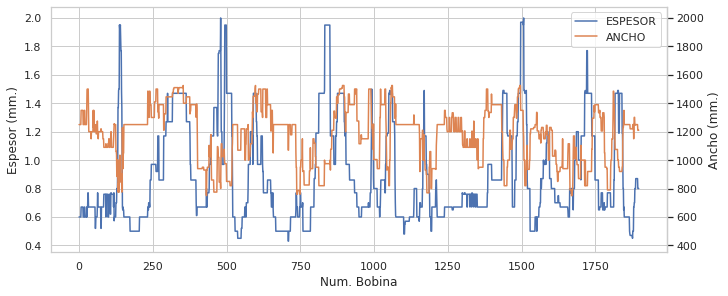

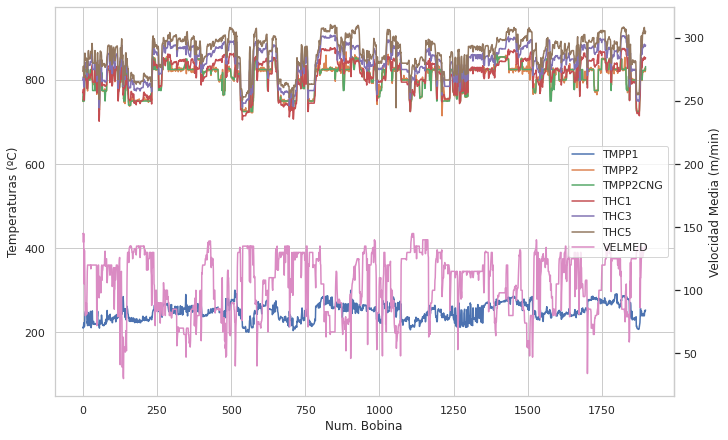

In [20]:
dibuja_proceso(df_train)

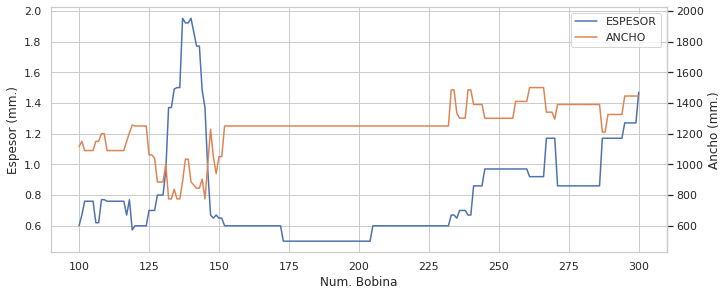

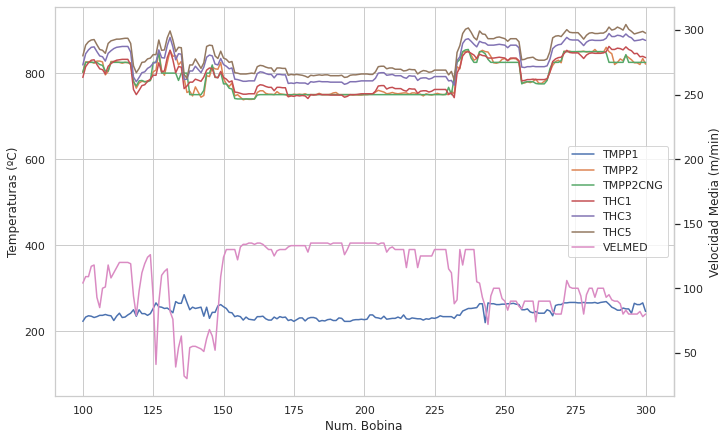

In [21]:
dibuja_proceso(df_train, pos_ini=100, num_bobs=200)

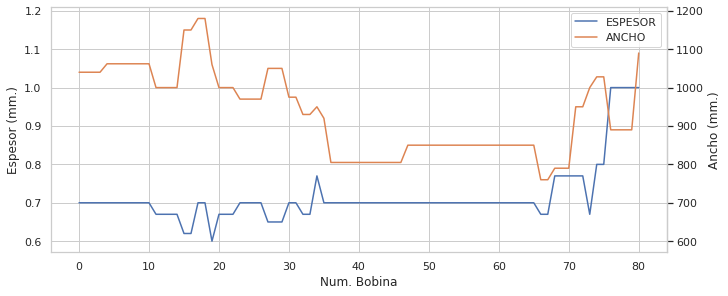

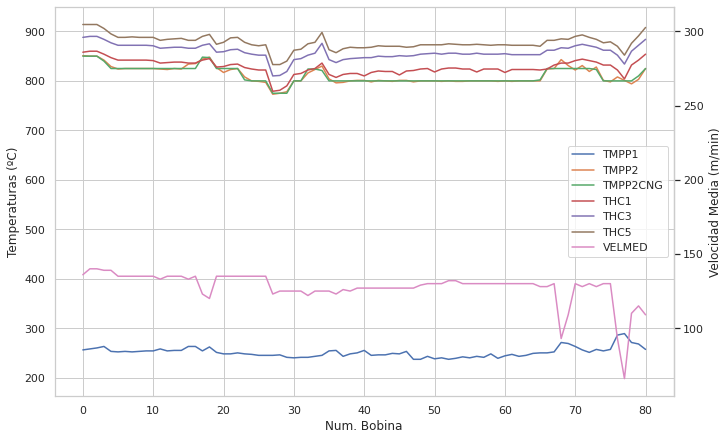

In [22]:
dibuja_proceso(df_test)

**EJERCICIO: Usando las funciones anteriores, visualiza tres momentos donde se produzcan cambios bruscos de velocidad y escribe tus conclusiones. Incluye el codigo que consideres necesario para justificar las mismas.**

**Representando la base de datos de entrenamiento:**

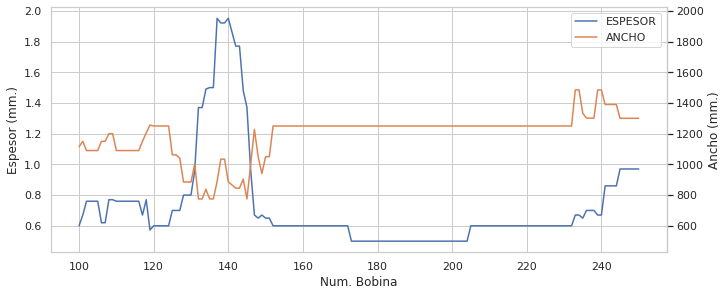

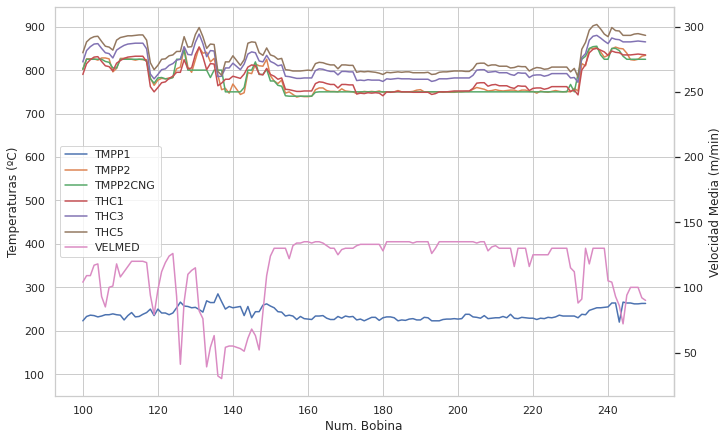

In [24]:
dibuja_proceso(df_train, pos_ini=100 ,num_bobs=150)

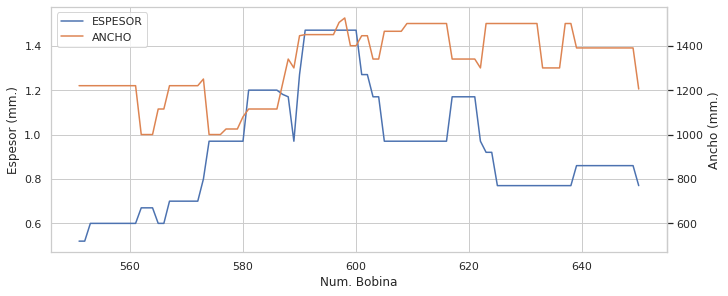

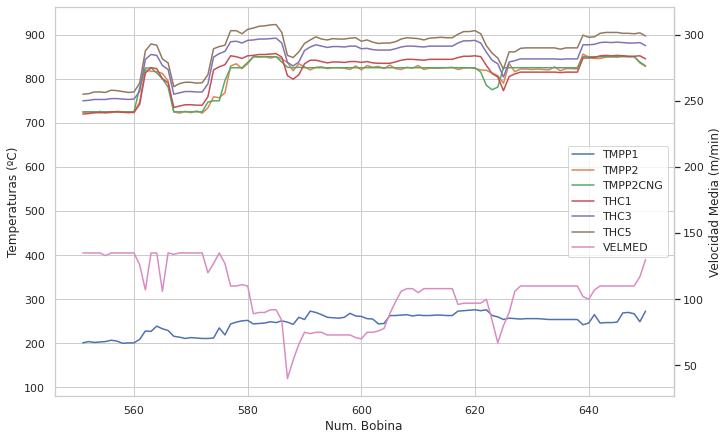

In [26]:
dibuja_proceso(df_train, pos_ini=550 ,num_bobs=100)

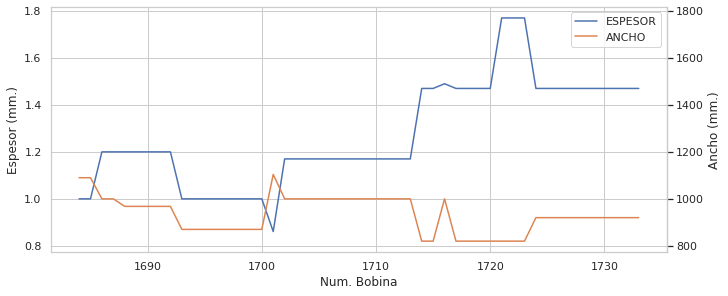

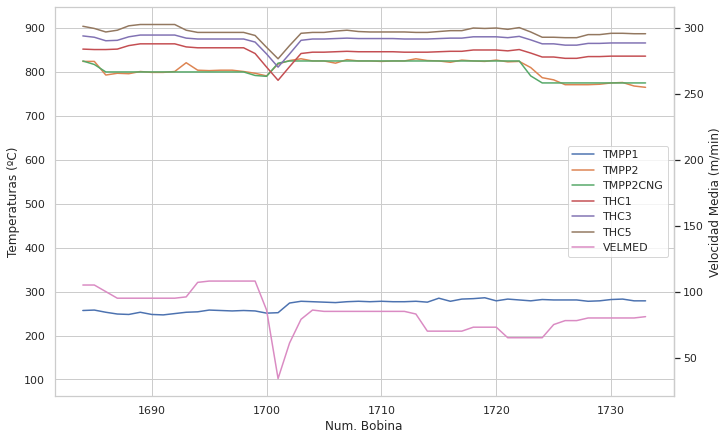

In [28]:
dibuja_proceso(df_train, pos_ini=1680 ,num_bobs=50)

En el primer caso se produce un descenso de la velocidad en picos esto podría ser debido a un mayor aumento del espesor de la bobina.

En el segundo caso hay dos picos hacia abajo de la velocidad que coinciden justo de forma similar con las temperaturas, lo cual podría deberse a un aumento del espesor y el ancho de la bobina.

En el tercer caso hay un descenso bastante pronunciado justo igual que en las temperaturas y en el espesor, pero en un aumento del ancho de la bobina.

**Representando la base de datos de testeo:**

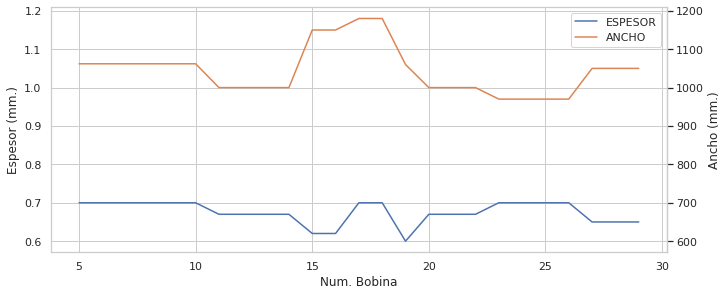

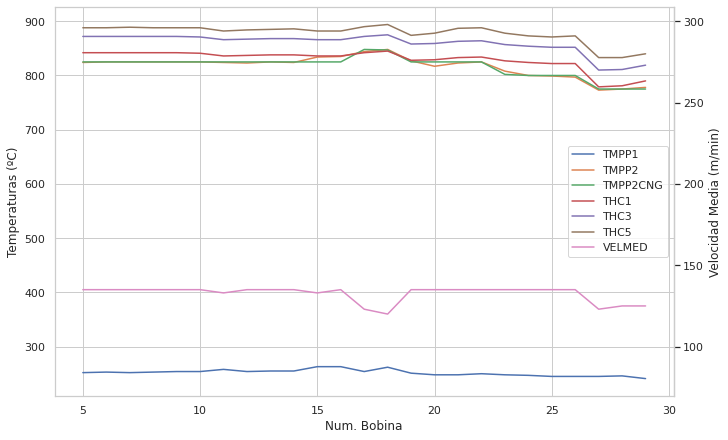

In [33]:
dibuja_proceso(df_test, pos_ini=5, num_bobs=25)

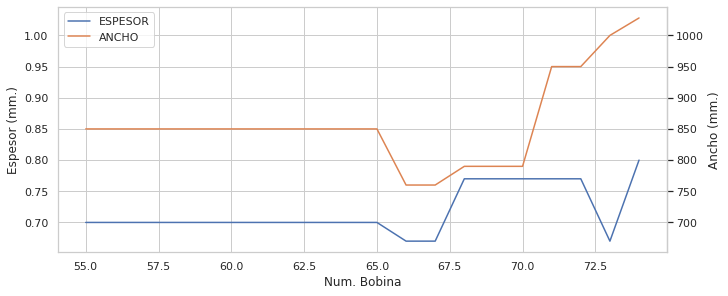

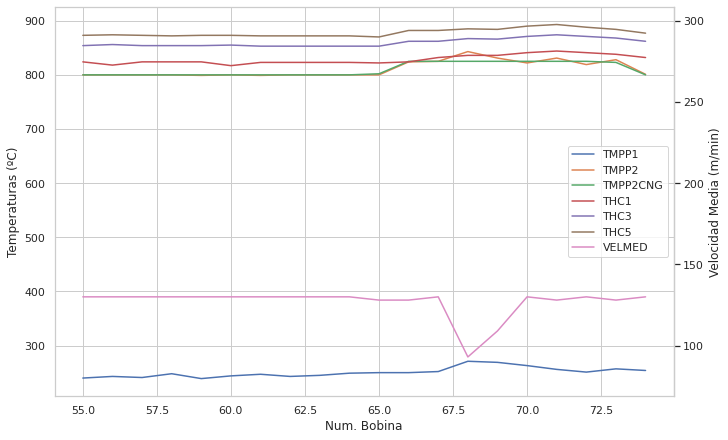

In [39]:
dibuja_proceso(df_test, pos_ini=55, num_bobs=20)

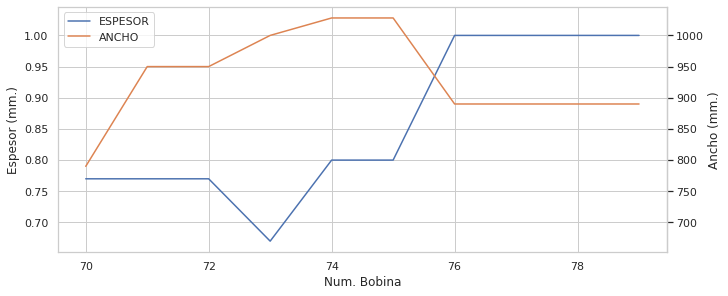

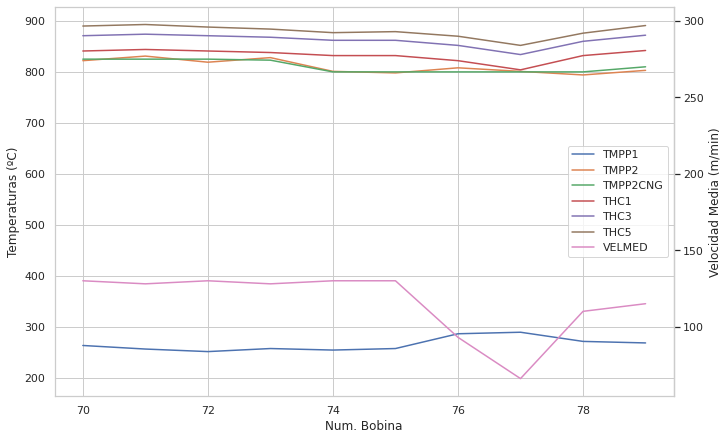

In [40]:
dibuja_proceso(df_test, pos_ini=70 ,num_bobs=10)

En los tres casos la velocidad hace un pico hacia abajo justo cuando el espesor de la bobina hace un mayor incremento y solo en uno en el primer caso también del ancho, con lo que se podría considerar que el ancho podría estar relacionado con la velocidad. 

Ahora mostramos la correlación entre features

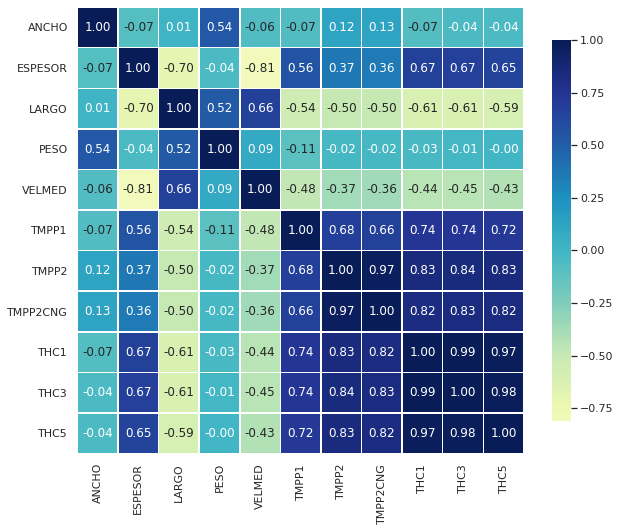

In [42]:
cols = ['ANCHO', 'ESPESOR', 'LARGO', 'PESO', 'VELMED',
       'TMPP1', 'TMPP2', 'TMPP2CNG', 'THC1', 'THC3', 'THC5']
corr = df_train[cols].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f', square=True,
            linewidths=.5, annot=True, cbar_kws={"shrink":.7},
            cmap="YlGnBu")
#            xticklabels=corr.columns,
#            yticklabels=corr.columns,
#             cmap="YlGnBu")

**EJERCICIO: Usando la gráfica de correlaciones anterior identifica las variables con correlación elevada y explica por qué crees que tienen una correlación tan alta. Incluye el codigo que consideres necesario para justificar las mismas.**

Como se puede observar en la gráfica de correlaciones tienen una mayor correlación entre sí las variables de temperatura con un valor superior a 0.7, esto podría ser debido a que en el proceso de galvanizado están muy próximas.

Vamos a dibujar el 'punto de operación' (PE) del proceso. El PE de un proceso o sistema es el estado en el que está el mismo en un momento de terminado. En el caso del proceso de galvanizado correspondería con la medición instantánea de las variables que influyen en el mismo. (velocidades, temperaturas, dimensiones del producto, etc.). De la proyección, vamos a eliminar algunas variables muy correladas entre si.

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Seleccionamos variables eliminando aquellas muy correladas o que no explican el PE
cols_pca = ['ANCHO', 'ESPESOR', 'VELMED', 'TMPP1', 'TMPP2', 'THC1']

# Estandarizamos todas las columnas
scaler = StandardScaler()
scaler.fit(df_train[cols_pca])
df_train_esc = scaler.transform(df_train[cols_pca])
df_test_esc = scaler.transform(df_test[cols_pca])

# Sacamos los dos primeros componentes PCA para usarlos como ejes x e y
pca = PCA(n_components=2)
pca.fit(df_train_esc)
print('Varianza explicada con los dos ejes:',np.sum(pca.explained_variance_ratio_))


Varianza explicada con los dos ejes: 0.7399525120297519


**EJERCICIO: ¿Son suficientes los dos primeros ejes del PCA según la varianza explicada? ¿Qué opinas?**

Si que serían suficientes los dos primeros ejes del PCA. La varianza indica la distribución que se encuentra el conjunto de valores.

Text(0.5, 1.0, 'Proyección del Punto de Operación usando PCA')

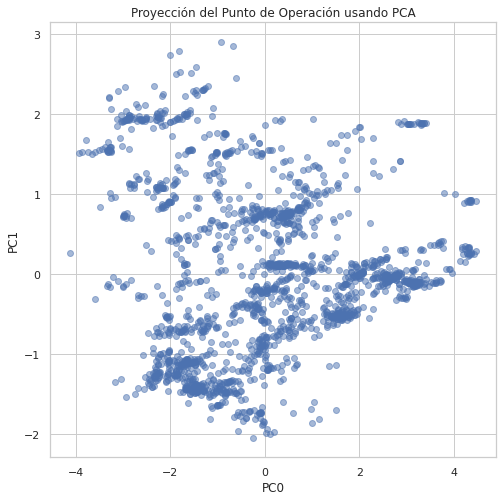

In [44]:
# Graficamos los puntos de operación proyectados en los dos ejes principales del PCA
proyeccion = pca.transform(df_train_esc)
plt.figure(figsize=(8,8))
plt.scatter(proyeccion[:,0],proyeccion[:,1],alpha=0.50)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Proyección del Punto de Operación usando PCA')

In [45]:
def saca_flechas(proyeccion, pos_ini=0, nump=10):
    proyec = proyeccion[pos_ini:pos_ini+nump]
    diff_proyec = np.diff(proyec,axis=0)

    plt.figure(figsize=(8,8))
    plt.scatter(proyeccion[:,0],proyeccion[:,1],alpha=0.10)
    plt.xlabel('PC0')
    plt.ylabel('PC1')
    plt.title('Recorrido del Punto de Operación usando PCA')
    for posrow in range(len(diff_proyec)):
        plt.arrow(x=proyec[posrow,0],y=proyec[posrow,1],
                  dx=diff_proyec[posrow,0],dy=diff_proyec[posrow,1],
                  color='red', linewidth=2.0,
                  head_width=0.1, head_length=0.1)

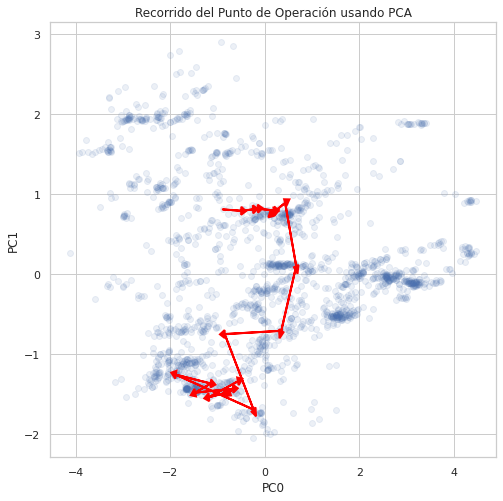

In [46]:
saca_flechas(proyeccion,pos_ini=1010,nump=20)

**EJERCICIO: Usando las funciones anteriores busca otros dos momentos donde se produzcan cambios bruscos en el punto de operación y muéstralos con la funcion 'saca_flechas()'. Incluye el codigo que consideres necesario para justificar las mismas.**
    

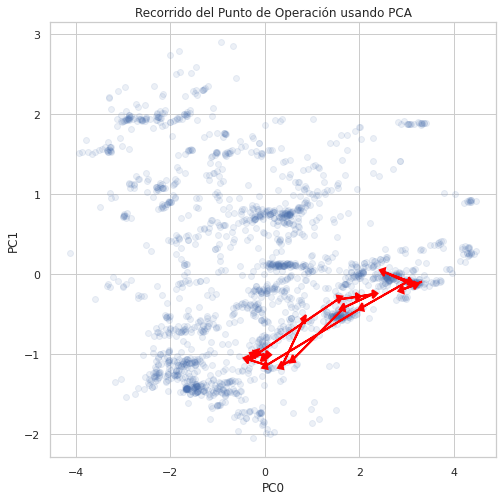

In [66]:
saca_flechas(proyeccion,pos_ini=1,nump=20)

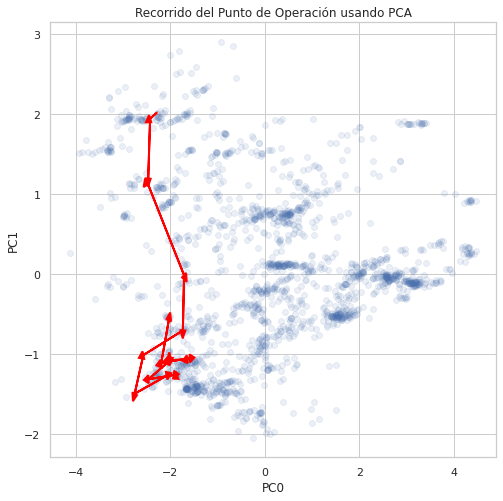

In [65]:
saca_flechas(proyeccion,pos_ini=1050,nump=20)

**EJERCICIO: Crea una nueva función basada en 'saca_flechas()' para poder mostrar los puntos de operación de la base de datos de testeo encima de la proyeccion PCA de los puntos de entrenamiento. ¿Están en una zona diferente? ¿Qué pasaría si es así?**

In [98]:
def saca_flechas_testeo(proyeccion, pos_ini=0, nump=10):
    proyec = proyeccion[pos_ini:pos_ini+nump]
    diff_proyec = np.diff(proyec,axis=0)

    plt.figure(figsize=(8,8))
    plt.scatter(proyeccion[:,0],proyeccion[:,1],alpha=0.10)
    plt.xlabel('PC0')
    plt.ylabel('PC1')
    plt.title('Recorrido del Punto de Operación usando PCA')
    for posrow in range(len(diff_proyec)):
        plt.arrow(x=proyec[posrow,0],y=proyec[posrow,1],
                  dx=diff_proyec[posrow,0],dy=diff_proyec[posrow,1],
                  color='red', linewidth=2.0,
                  head_width=0.1, head_length=0.1)

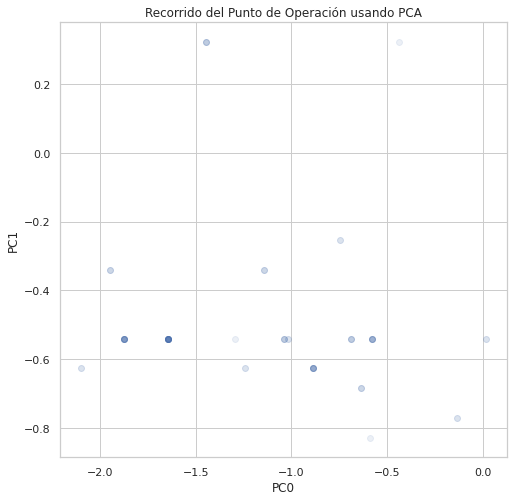

In [112]:
saca_flechas_testeo(df_test_esc, pos_ini=1, nump=10)

**EJERCICIO: Usa otros tipos de proyecciones (ISOMAP, LLE, MDS, T-SNE, etc.) para visualizar el punto de operación. Mínimo dos!**

**Usando ISOMAP:**

Text(0.5, 1.0, 'Proyección del Punto de Operación usando ISOMAP')

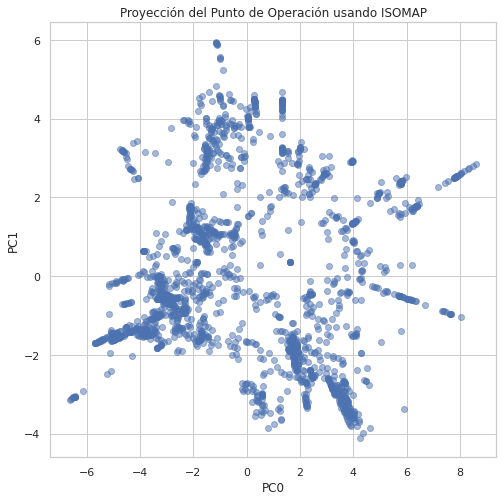

In [94]:
# Graficamos los puntos de operación proyectados en los dos ejes principales del ISOMAP
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2) 
iso1 = embedding.fit_transform(df_train_esc)
plt.figure(figsize=(8,8))
plt.scatter(iso1[:,0],iso1[:,1],alpha=0.50)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Proyección del Punto de Operación usando ISOMAP')

**Usando T-SNE:**

Text(0.5, 1.0, 'Proyección del Punto de Operación usando T-SNE')

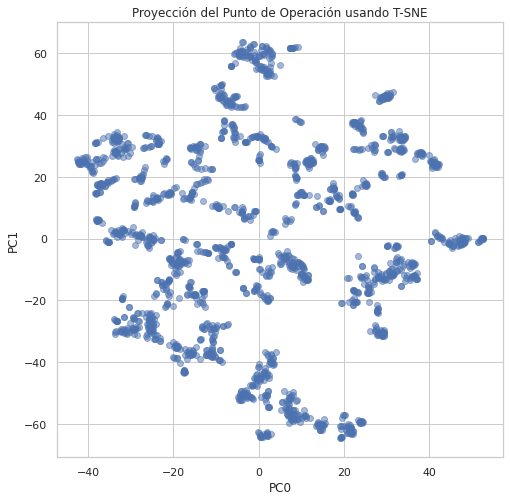

In [97]:
# Graficamos los puntos de operación proyectados en los dos ejes principales del T-SNE
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2)
tsne1 = embedding.fit_transform(df_train_esc)
plt.figure(figsize=(8,8))
plt.scatter(tsne1[:,0],tsne1[:,1],alpha=0.50)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title('Proyección del Punto de Operación usando T-SNE')

# ENTREGA

Recuerda guardar tus cambios en tu repositorio utilizando la opción "Save a copy in GitHub..." del menú File.